In [1]:
import os
import re
import json
import pandas as pd
from collections import Counter
import spacy
from spacy.tokens import Doc

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn

sentiment_analyzer = SentimentIntensityAnalyzer()
def polarity_scores(doc):
    return sentiment_analyzer.polarity_scores(doc.text)
Doc.set_extension('polarity_scores', getter=polarity_scores)
nlp = spacy.load("en_core_web_lg")    

from tqdm import tqdm


In [2]:
convTimelineCell = 42
minLines = 50
stripPersonnas = True
main = ['jerry', 'summer', 'beth', 'rick', 'morty', 'pickle rick', 'unity']
keysToRemove = ['fullText', 'pron', 'lines']
replace = {
    'rick sanches': 'rick',
    'drunk rick': 'rick',
    'morty smith': 'morty',
    'gromfomite': 'gromflomite',
    'other gromflomite': 'gromflomite',
    'gromflomite captain': 'gromflomite',
    'gromflomite worker': 'gromflomite',
    'gromflomite guard': 'gromflomite',
    'gromflomite office employee': 'gromflomite',
    'rick salseman': 'rick salesman',
    'armed ricks': 'armed rick',
    'all religious mortys': 'religious morty',
    'little tommy': 'tommy',
    'meeseek': 'meeseeks',
    'all the meeseeks': 'meeseeks',
    'all other meeseeks': 'meeseeks',
    'mailmen': 'mailman',
    'gerry': 'jerry'
    
}
ignore = [
    'a mexican armada shows up. with weapons made from two', 
    'pa system', 
    'all classmates except morty',
    'another voice',
    'sexualized s',
    'both']

#main = ['beth']
data = {
    'characters': {},
}

In [3]:
wordsDf = pd.DataFrame(columns=['words'])
 
def do_nlp(character, line, file, section):
    non_actions = re.sub(r'\[.*\]|\(.*\)', '', line)
    non_actions = re.sub(r'[!\.\?\;\"\-\*]', ' ', non_actions)
    non_actions = re.sub(r'([a-z])\1{2,}',r'\1', non_actions)

    text = '';
    
    doc = nlp(non_actions)
    
    for token in doc:
        if (token.lemma_ != '-PRON-'):        
            text = text + token.lemma_ + ' '        
    
    character['fullText'] += non_actions    
    score = doc._.polarity_scores['compound']

    actualVal =  character['sentiment'][section] if character['sentiment'][section] != False else 0
    character['sentiment'][section] = (actualVal + score) / 2
    
    actualVal =  character['episodes'][file]['sentiment'][section] if character['episodes'][file]['sentiment'][section] != False else 0
    character['episodes'][file]['sentiment'][section] = (actualVal + score) / 2
    
    if abs(score)>.2:
        character['episodes'][file]['sentimentLine'][section] += non_actions;

In [4]:
def getCharacter(characterName):
    characters = data['characters']
    try:
        character = characters[characterName]
    except KeyError:
        character = characters[characterName] = {
            'linesCount': 0, 
            'lines': [], 
            'time': [0] * convTimelineCell, 
            
            'episodes': {},
            'pron': {},
            'fullText': ''
        }
        if characterName in main:
            character['sentiment'] = ([False] * convTimelineCell)
            character['sentimentLine'] = ([''] * convTimelineCell)

    return character

def parseLine(characterName, line, file, section):
    character = getCharacter(characterName)    
    character['linesCount'] += 1    
    episodes = character['episodes']
    
    try: 
        episode = episodes[file]
    except:
        episode = episodes[file] = {
            'linesCount': 0,
            'time': [0]*convTimelineCell,
            
        }
        if characterName in main:
            episode['sentiment'] = ([False] * convTimelineCell)
            episode['sentimentLine'] = ([''] * convTimelineCell)
        
    character['time'][section] += 1
    episode['time'][section] += 1
    episode['linesCount'] += 1
    
    if characterName in main:
        do_nlp(character, line, file, section)

In [5]:
files = os.listdir("./parsed")
for filename in files:
    print('Processing: ', filename)
    lines = 0
    with open("./parsed/" + filename, "r") as f:             
        for line in f:            
            lines += 1
            
    with open("./parsed/" + filename, "r") as f:                    
        index = 0
        for line in tqdm(f, total=lines): 
            if stripPersonnas == True:
                find = re.search(r"^([a-zA-Z][a-zA-Z \.]+).*\:(.*)", line) 
            else:
                find = re.search(r"^([a-z][a-z0-9 \(\)]+):(.*)", line)

            if find:
                name = find.group(1).strip()
                text = find.group(2).strip()
                if name not in ignore:
                    try:
                        actualName = replace[name]
                    except:
                        actualName = name
                    
                    parseLine(actualName, text, filename[6:len(filename)-4], int(index * convTimelineCell / lines))
            index += 1

  8%|▊         | 19/245 [00:00<00:01, 186.07it/s]

Processing:  011 - Ricksy Business.txt


 10%|█         | 27/262 [00:00<00:00, 263.67it/s]

Processing:  021 - The Wedding Squanchers.txt


  7%|▋         | 23/319 [00:00<00:01, 229.93it/s]

Processing:  015 - Total Rickall.txt


  6%|▌         | 21/347 [00:00<00:01, 204.25it/s]

Processing:  020 - Look Who's Purging Now.txt


  7%|▋         | 16/224 [00:00<00:01, 157.91it/s]

Processing:  029 - Morty's Mind Blowers.txt


  7%|▋         | 19/287 [00:00<00:01, 181.80it/s]

Processing:  001 - Pilot.txt


  7%|▋         | 23/340 [00:00<00:01, 227.99it/s]

Processing:  010 - Close Rick-counters of the Rick Kind.txt


  5%|▌         | 15/287 [00:00<00:01, 143.89it/s]

Processing:  026 - The Whirly Dirly Conspiracy.txt


  7%|▋         | 26/358 [00:00<00:01, 257.72it/s]

Processing:  002 - Lawnmower Dog.txt


 12%|█▏        | 51/411 [00:00<00:00, 500.64it/s]

Processing:  016 - Get Schwifty.txt


  9%|▊         | 20/235 [00:00<00:01, 190.43it/s]

Processing:  024 - Pickle Rick.txt


  8%|▊         | 31/365 [00:00<00:01, 294.28it/s]

Processing:  022 - The Rickshank Redemption.txt


  8%|▊         | 43/559 [00:00<00:01, 426.70it/s]

Processing:  007 - Raising Gazorpazorp.txt


  6%|▌         | 15/270 [00:00<00:01, 147.33it/s]

Processing:  018 - Big Trouble In Little Sanchez.txt


 11%|█         | 36/337 [00:00<00:00, 345.86it/s]

Processing:  014 - Auto Erotic Assimilation.txt


  6%|▌         | 20/323 [00:00<00:01, 199.19it/s]

Processing:  030 - The ABCs of Beth.txt


 32%|███▏      | 36/113 [00:00<00:00, 348.62it/s]

Processing:  006 - Rick Potion 9.txt


  6%|▌         | 24/432 [00:00<00:01, 236.91it/s]

Processing:  008 - Rixty Minutes.txt


  6%|▌         | 25/444 [00:00<00:01, 249.46it/s]

Processing:  003 - Anatomy Park.txt


  8%|▊         | 30/378 [00:00<00:01, 296.04it/s]

Processing:  009 - Something Ricked This Way Comes.txt


  6%|▌         | 22/377 [00:00<00:01, 207.65it/s]

Processing:  013 - Mortynight Run.txt


  9%|▊         | 28/321 [00:00<00:01, 264.24it/s]

Processing:  005 - Meeseeks and Destroy.txt


  7%|▋         | 21/295 [00:00<00:01, 208.03it/s]

Processing:  004 - M. Night Shaym-Aliens!.txt


  5%|▌         | 20/376 [00:00<00:01, 194.73it/s]

Processing:  023 - Rickmancing the Stone.txt


  5%|▌         | 22/411 [00:00<00:01, 217.76it/s]

Processing:  012 - A Rickle in Time.txt


100%|██████████| 411/411 [00:01<00:00, 332.93it/s]


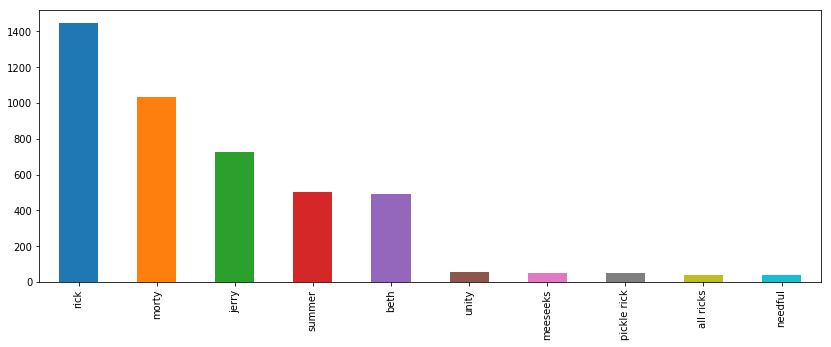

In [87]:
# toRemove = []
# characters = data['characters']
# data['allCharacterNames'] = set(characters.keys())
# for key in characters.keys():
#     count = characters[key]['linesCount']
#     if count < minLines:
#         toRemove.append(key)
        
# for keyToRemove in toRemove:
#     del characters[keyToRemove]
    
# print(characters.keys())
#pd.DataFrame(data['characters'], columns=['words','count']).set_index('words').plot(legend = False, kind='bar', title=key);
# pd.DataFrame(data['characters']).set_index('linesCount').plot(legend = False, kind='bar', title=key);
#pd.DataFrame.from_dict(data['characters'], orient='index').plot(y='linesCount', legend = False, kind='bar');
talkDf = pd.DataFrame.from_dict(data['characters'], orient='index').sort_values(by=['linesCount'], ascending = False)[:10].plot(y='linesCount', legend = False, kind='bar', figsize=(14,5))


In [53]:

for key in main[:5]:
    try:
        character = data['characters'][key]
        full_text = character['fullText']
        doc = nlp(full_text)
        non_words = [token.text for token in doc if token.has_vector == False and len(token.text.strip()) > 2]
        nw_freq = Counter(non_words)
        print(key)
        print(nw_freq)
    except KeyError:
        print('err')
        pass

jerry
Counter({'taddi': 3, 'meeseeks': 3, 'r2d2s': 2, 'dirly': 2, 'scroopy': 2, 'noopers': 2, 'cervine': 2, "kitchenyou're": 1, 'deviceit': 1, 'birdperson': 1, 'squanch': 1, 'rick—': 1, 'c’mere': 1, 'telepod': 1, 'uhnot': 1, 'smiggle': 1, 'maybewhat': 1, "wasn'tso": 1, 'hawkinson': 1, 'gargler': 1, 'krootabulan': 1, 'krootabulon': 1, 'varrix': 1, 'cheetara': 1, 'plutonians': 1, 'don’t': 1, 'marklevitz': 1, 'you—': 1})
summer
Counter({'taddi': 2, 'palicky': 2, 'switchooh': 1, 'offscreenno': 1, 'birdperson': 1, 'squanchy': 1, "family'd": 1, 'tinkes': 1, 'poopybutthole': 1, 'gazorpazorp': 1, 'superknowledge': 1, 'phisosophers': 1, 'gagoo': 1, 'froopyland': 1, 'hymencholo': 1, 'zuckerberging': 1, 'carpin': 1})
beth
Counter({'squanch': 3, 'meeseeks': 3, 'froopy': 2, 'devicei': 1, 'wineboxi': 1, 'poopybutthole': 1, 'taddi': 1, 'andteenage': 1, 'thatoh': 1, 'barkered': 1, 'i‘m': 1, 'youbadass': 1, 'froopyland': 1, 'isokay': 1, 'beenam': 1})
rick
Counter({'birdperson': 6, 'froopyland': 5, 'pen

In [7]:

for key in main[:5]:
    try:
        character = data['characters'][key]
        full_text = character['fullText']
        doc = nlp(full_text)
        nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]
        word_freq = Counter(nouns)
        character['common_words'] = word_freq.most_common(50)    
        print('-'.join(['-']*10))
        print(key)
        print(character['common_words'])
    except KeyError:
        
        pass

-------------------
jerry
[('morty', 24), ('planet', 23), ('guys', 20), ('son', 19), ('thing', 18), ('summer', 18), ('time', 18), ('family', 16), ('father', 16), ('rick', 13), ('jerry', 12), ('house', 11), ('science', 11), ('way', 10), ('life', 8), ('honey', 8), ('wife', 8), ('people', 7), ('fun', 7), ('hell', 7), ('gary', 7), ('guy', 7), ('christmas', 7), ('kids', 7), ('things', 7), ('pluto', 7), ('idea', 6), ('school', 6), ('friend', 6), ('head', 6), ('dad', 6), ('man', 6), ('apples', 6), ('deer', 6), ('tv', 5), ('device', 5), ('job', 5), ('love', 5), ('milk', 5), ('home', 5), ('face', 5), ('kind', 5), ('dog', 5), ('mom', 5), ('cloud', 4), ('atlas', 4), ('tru', 4), ('surgeon', 4), ('game', 4), ('movie', 4)]
-------------------
summer
[('dad', 39), ('grandpa', 39), ('morty', 25), ('rick', 19), ('mom', 12), ('guys', 11), ('people', 8), ('head', 7), ('time', 7), ('unity', 7), ('drum', 7), ('pants', 6), ('school', 6), ('place', 6), ('parents', 5), ('thing', 5), ('family', 5), ('god', 5),

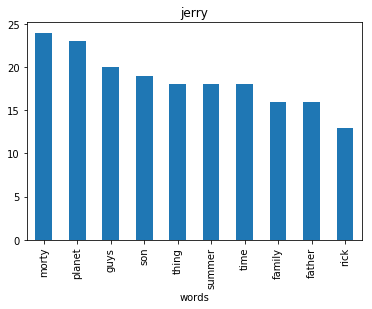

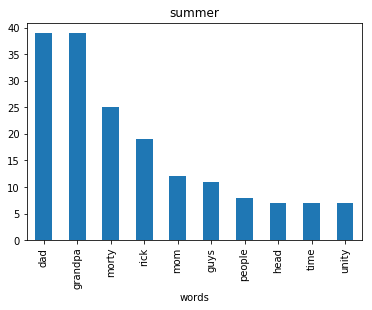

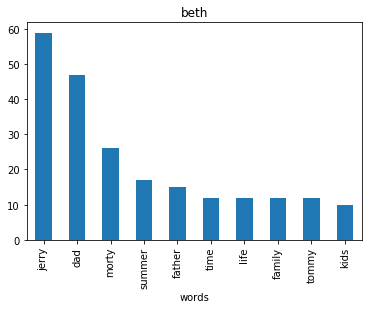

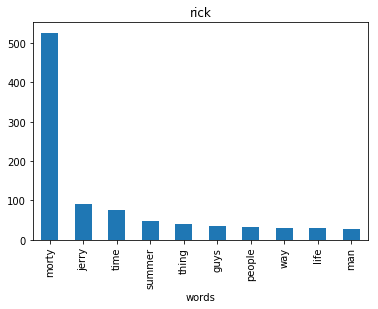

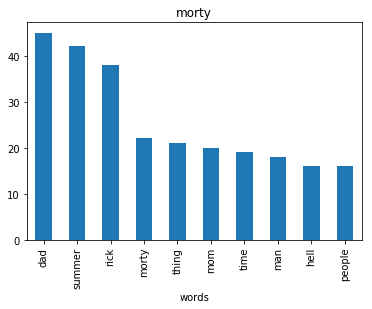

In [34]:
for key in main[:5]:
    characterData = data['characters'][key]['common_words'][:10];
    pd.DataFrame(characterData, columns=['words','count']).set_index('words').plot(legend = False, kind='bar', title=key);

In [8]:
"""
for key in main:
    try:
        character = data['characters'][key]
        full_text = character['fullText']
        doc = nlp(full_text)
        nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]
        word_freq = Counter(nouns)
        character['common_words'] = word_freq.most_common(50)    
        print('-'.join(['-']*10))
        print(key)
        print(character['common_words'])
    except KeyError:
        pass

for key in data['characters'].keys():    
    character = data['characters'][key]
    for keyToRemove in keysToRemove:
        try:
            del character[keyToRemove]
        except KeyError:
            pass
    episodes = character['episodes']
    
    for episode in episodes.keys():
        print(episode)
        for keyToRemove in keysToRemove:
            try:
                del character['episodes'][episode][keyToRemove]
            except KeyError:
                pass

"""
    
    

'\nfor key in main:\n    try:\n        character = data[\'characters\'][key]\n        full_text = character[\'fullText\']\n        doc = nlp(full_text)\n        nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]\n        word_freq = Counter(nouns)\n        character[\'common_words\'] = word_freq.most_common(50)    \n        print(\'-\'.join([\'-\']*10))\n        print(key)\n        print(character[\'common_words\'])\n    except KeyError:\n        pass\n\nfor key in data[\'characters\'].keys():    \n    character = data[\'characters\'][key]\n    for keyToRemove in keysToRemove:\n        try:\n            del character[keyToRemove]\n        except KeyError:\n            pass\n    episodes = character[\'episodes\']\n    \n    for episode in episodes.keys():\n        print(episode)\n        for keyToRemove in keysToRemove:\n            try:\n                del character[\'episodes\'][episode][keyToRemove]\n            except 

In [9]:
with open('data.json', 'w') as fp:
    json.dump(data, fp)

In [10]:
data['characters'].keys()

dict_keys(['bachelor', 'jerry', 'summer', 'beth', 'rick', 'morty', 'corn man', 'glenn', 'letterman', 'woman', 'announcer', 'shmlony', 'host in trenchcoat', 'cop', 'killer', 'judge', 'man', 'ants', 'mr. sneezy', 'fake doors salesman', 'gazorpazorpfield', 'jon', 'spokesman', 'suspender guy', 'garbageman', 'spokeman', 'trunkperson', 'new yorker', 'mr. tophat jones', 'unmuscular michael', 'police cheif', 'regular legs', 'baby legs', 'police chief', 'criminal', 'business man', 'news anchor', 'courier flap', 'birdperson', 'tammy', 'squanchy', 'pat', 'bartender', 'all', 'cyborg photographer', 'diane', 'computer', 'agent', 'officer', 'customs', 'prisoner', 'mr. poopybutthole', 'uncle steve', 'poopybutthole', 'nicky', 'nazi', 'mr. beauregard', 'frankenstein', 'sleepy gary', 'pencilvester', 'tinkles', 'gary', 'hamurai', 'amish cyborg', 'reverse giraffe', 'ghost in a jar', 'mrs. refrigerator', 'reverse', 'duck with muscles', 'mrs refrigerator', 'cross teddy bear', 'doctor', 'farmer', 'general sto